In [8]:
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, pipeline
import torch
import pandas as pd

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns


In [5]:
df_combined = pd.read_csv("../aggregated_data/combined_review_data.csv")

In [6]:
df_combined.head()

,review,review_datetime,data_source,app_name,upvote_count,total_comments,app_rating
0,uber eats for owls? will they ever come out wi...,2025-04-20 21:51:15,Reddit,UberEats,1.0,2.0,NaN
1,serious question yall is it worth going out to...,2025-04-20 21:41:21,Reddit,UberEats,1.0,1.0,NaN
2,ubereats charged me for a successful chargebac...,2025-04-20 20:50:04,Reddit,UberEats,1.0,2.0,NaN
3,ubereats driver scammed me by buying half the ...,2025-04-20 20:48:13,Reddit,UberEats,1.0,9.0,NaN
4,ubereats why you do this? family went out of t...,2025-04-20 20:19:15,Reddit,UberEats,1.0,3.0,NaN


In [7]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126725 entries, 0 to 126724
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   review           126716 non-null  object 
 1   review_datetime  126725 non-null  object 
 2   data_source      126725 non-null  object 
 3   app_name         126725 non-null  object 
 4   upvote_count     126290 non-null  float64
 5   total_comments   21157 non-null   float64
 6   app_rating       105133 non-null  float64
dtypes: float64(3), object(4)
memory usage: 6.8+ MB


In [8]:
df_combined.shape

(126725, 7)

## Sentiment Analysis

In [9]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Chirag\Rutgers\Sem 2\Data Wrangling\Project\data-wrangling-etl\dwproj\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chira\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [14]:
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [15]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Postive"
}


In [16]:
def safe_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "Neutral"
    try:
        # Truncate input text at tokenizer level
        result = sentiment_analyzer(
            text,
            truncation=True,
            max_length=512
        )[0]
        return label_map.get(result['label'], "UNKNOWN")
    except Exception as e:
        print(f"Error processing text: {e}")
        return "ERROR"

In [17]:
df_combined['sentiment'] = df_combined['review'].apply(safe_sentiment)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [18]:
df_combined['sentiment'].value_counts()

sentiment
Negative    62305
Postive     45037
Neutral     19383
Name: count, dtype: int64

In [19]:
df_combined.to_csv("../aggregated_data/combined_review_data_with_sentiment.csv", index=False)


# Topic Modeling

In [20]:

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:


# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text) or text == "":
        return []

    # Convert to lowercase and tokenize
    tokens = simple_preprocess(str(text), deacc=True)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words and len(word) > 3]


In [22]:
def perform_lda(reviews, num_topics=5):
    # Create dictionary
    dictionary = corpora.Dictionary(reviews)

    # Filter out extreme values (optional)
    dictionary.filter_extremes(no_below=5, no_above=0.7)

    # Create document-term matrix
    corpus = [dictionary.doc2bow(review) for review in reviews]

    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )

    return lda_model, corpus, dictionary

In [23]:
def display_topics(lda_model, num_topics, top_words=10):
    for topic_id in range(num_topics):
        print(f"Topic {topic_id + 1}:")
        words = lda_model.show_topic(topic_id, top_words)
        print(", ".join([word for word, prob in words]))
        print()

In [24]:
# Process the reviews for each unique app
unique_apps = df_combined['app_name'].unique()
print(f"Found {len(unique_apps)} unique apps: {', '.join(unique_apps)}")

for app in unique_apps:
    print(f"\n\n{'='*50}")
    print(f"Processing reviews for: {app}")
    print(f"{'='*50}")

    # Filter data for this app
    app_data = df_combined[df_combined['app_name'] == app]

    # Preprocess reviews
    reviews = app_data['review'].apply(preprocess_text).tolist()

    # Remove empty reviews
    reviews = [r for r in reviews if len(r) > 0]

    print(f"Number of reviews after preprocessing: {len(reviews)}")

    if len(reviews) < 10:
        print(f"Too few reviews for {app} after preprocessing. Skipping...")
        continue

    # Determine appropriate number of topics based on dataset size
    num_topics = min(5, max(2, len(reviews) // 100))

    # Perform LDA
    print(f"Training LDA model with {num_topics} topics...")
    lda_model, corpus, dictionary = perform_lda(reviews, num_topics)

    # Display results
    print(f"\nTop words for each topic in {app}:")
    display_topics(lda_model, num_topics)

    # Calculate coherence score
    from gensim.models.coherencemodel import CoherenceModel
    coherence_model = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score: {coherence_score:.4f}")

Found 3 unique apps: UberEats, DoorDash, GrubHub


Processing reviews for: UberEats
Number of reviews after preprocessing: 63262
Training LDA model with 5 topics...

Top words for each topic in UberEats:
Topic 1:
food, driver, order, delivery, ordered, delivered, hour, minutes, address, away

Topic 2:
uber, eats, like, better, orders, delivery, fees, much, make, people

Topic 3:
food, service, great, delivery, always, time, love, easy, drivers, fast

Topic 4:
good, best, convenient, reliable, promos, life, useful, wonderful, pathetic, pretty

Topic 5:
order, uber, customer, refund, service, never, money, support, even, eats

Coherence Score: 0.5581


Processing reviews for: DoorDash
Number of reviews after preprocessing: 52884
Training LDA model with 5 topics...

Top words for each topic in DoorDash:
Topic 1:
delivery, fees, doordash, expensive, better, much, uber, prices, awesome, restaurants

Topic 2:
food, time, like, always, drivers, driver, delivery, order, dashers, convenient

To

In [27]:
def find_optimal_topics(reviews, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        dictionary = corpora.Dictionary(reviews)
        dictionary.filter_extremes(no_below=5, no_above=0.7)
        corpus = [dictionary.doc2bow(review) for review in reviews]

        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        model_list.append(lda_model)

        coherence_model = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    # Return the model with the highest coherence score
    optimal_model_index = coherence_values.index(max(coherence_values))
    optimal_model = model_list[optimal_model_index]
    optimal_topics = range(start, limit, step)[optimal_model_index]

    return optimal_model, optimal_topics, max(coherence_values), coherence_values

Found 3 unique apps: UberEats, DoorDash, GrubHub


Processing reviews for: UberEats
Number of reviews after preprocessing: 63262
Finding optimal number of topics between 2 and 20...
Optimal number of topics for UberEats: 3 with coherence score 0.5752

Top words for each topic in UberEats (Optimal model with 3 topics):
Topic 1:
driver, card, house, payment, ordered, door, food, picture, account, said

Topic 2:
order, uber, food, customer, service, refund, eats, never, time, delivery

Topic 3:
good, great, service, always, delivery, food, love, easy, uber, fees


Running final LDA model with optimal 3 topics for UberEats...
Final Coherence Score: 0.5752


Processing reviews for: DoorDash
Number of reviews after preprocessing: 52884
Finding optimal number of topics between 2 and 20...
Optimal number of topics for DoorDash: 6 with coherence score 0.5827

Top words for each topic in DoorDash (Optimal model with 6 topics):
Topic 1:
fees, expensive, delivery, prices, price, restaurants, worth

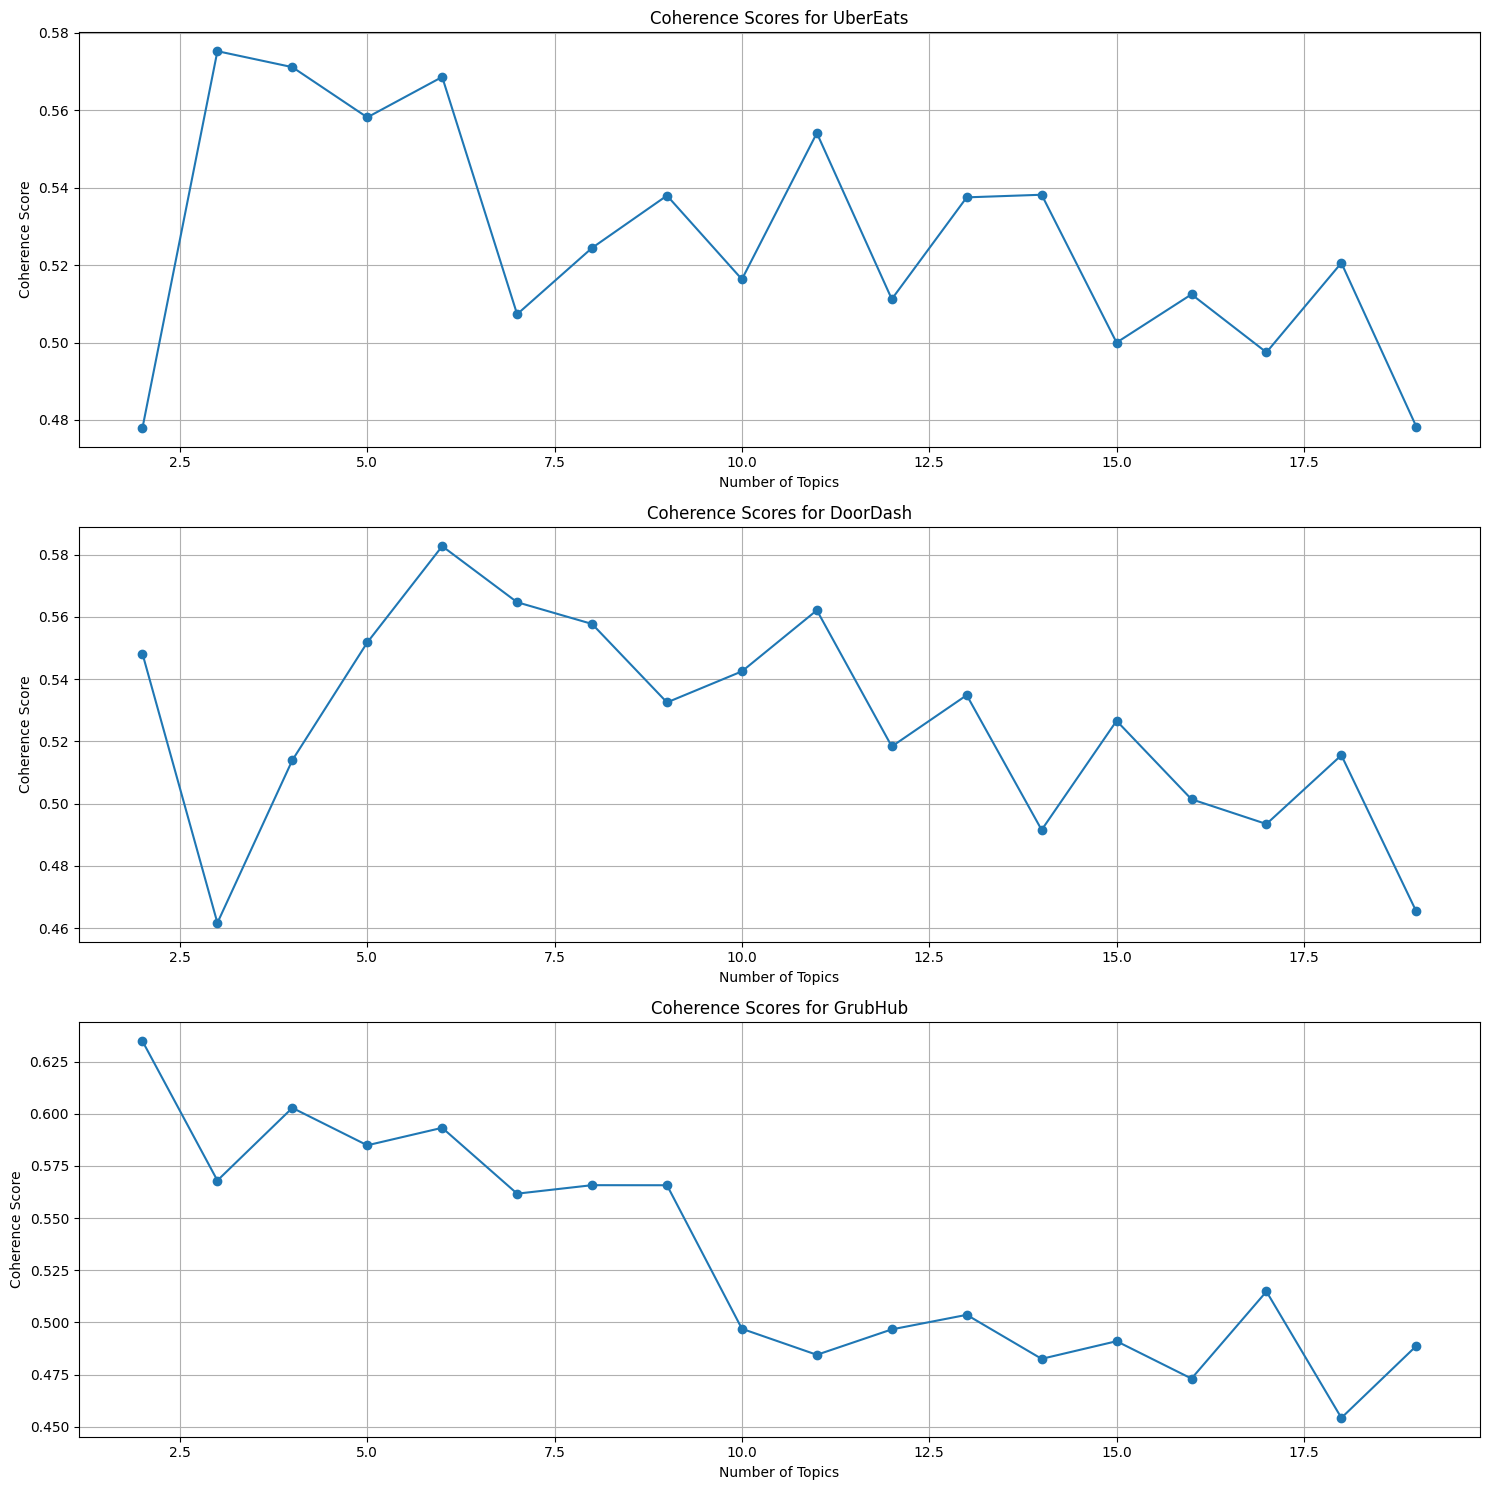

Stored optimal model for UberEats with 3 topics (coherence: 0.5752)
Stored optimal model for DoorDash with 6 topics (coherence: 0.5827)
Stored optimal model for GrubHub with 2 topics (coherence: 0.6348)

Optimal Topic Summary:
   App Name  Optimal Topics  Coherence Score
0  UberEats               3         0.575200
1  DoorDash               6         0.582711
2   GrubHub               2         0.634814


In [ ]:
# Process the reviews for each unique app
unique_apps = df_combined['app_name'].unique()
print(f"Found {len(unique_apps)} unique apps: {', '.join(unique_apps)}")

# Set up a figure for all coherence plots
plt.figure(figsize=(15, 5*len(unique_apps)))

# Process each app
for i, app in enumerate(unique_apps):
    print(f"\n\n{'='*50}")
    print(f"Processing reviews for: {app}")
    print(f"{'='*50}")

    # Filter data for this app
    app_data = df_combined[df_combined['app_name'] == app]

    # Preprocess reviews
    app_reviews = app_data['review'].apply(preprocess_text).tolist()

    # Remove empty reviews
    app_reviews = [r for r in app_reviews if len(r) > 0]

    print(f"Number of reviews after preprocessing: {len(app_reviews)}")

    if len(app_reviews) < 10:
        print(f"Too few reviews for {app} after preprocessing. Skipping...")
        continue

    # Find optimal number of topics
    start_topics = 2
    limit_topics = min(20, max(10, len(app_reviews) // 50))  # Adjust based on dataset size
    step = 1

    print(f"Finding optimal number of topics between {start_topics} and {limit_topics}...")
    optimal_model, optimal_topics, best_coherence, coherence_values = find_optimal_topics(
        app_reviews, start=start_topics, limit=limit_topics, step=step
    )

    print(f"Optimal number of topics for {app}: {optimal_topics} with coherence score {best_coherence:.4f}")

    # Plot coherence scores for this app
    plt.subplot(len(unique_apps), 1, i+1)
    plt.plot(range(start_topics, limit_topics, step), coherence_values, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title(f"Coherence Scores for {app}")
    plt.grid(True)

    # Display the optimal topics
    print(f"\nTop words for each topic in {app} (Optimal model with {optimal_topics} topics):")
    display_topics(optimal_model, optimal_topics)

    # Prepare corpus and dictionary for this model
    dictionary = corpora.Dictionary(app_reviews)
    dictionary.filter_extremes(no_below=5, no_above=0.7)
    corpus = [dictionary.doc2bow(review) for review in app_reviews]

    # Uncomment to visualize topics interactively (requires notebook environment)
    # vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
    # pyLDAvis.display(vis)

    # For demonstration, let's also run the model with optimal topics
    print(f"\nRunning final LDA model with optimal {optimal_topics} topics for {app}...")
    final_lda_model, final_corpus, final_dictionary = perform_lda(app_reviews, optimal_topics)

    # Calculate final coherence score
    final_coherence_model = CoherenceModel(
        model=final_lda_model, texts=app_reviews, dictionary=final_dictionary, coherence='c_v'
    )
    final_coherence_score = final_coherence_model.get_coherence()
    print(f"Final Coherence Score: {final_coherence_score:.4f}")

plt.tight_layout()
plt.show()

# Creating a dictionary to store all the optimal models
optimal_models = {}

for app in unique_apps:
    # Filter data for this app
    app_data = df_combined[df_combined['app_name'] == app]

    # Preprocess reviews
    app_reviews = app_data['review'].apply(preprocess_text).tolist()
    app_reviews = [r for r in app_reviews if len(r) > 0]

    if len(app_reviews) < 10:
        continue

    # Find optimal number of topics again
    start_topics = 2
    limit_topics = min(20, max(10, len(app_reviews) // 50))
    optimal_model, optimal_topics, best_coherence, _ = find_optimal_topics(
        app_reviews, start=start_topics, limit=limit_topics, step=1
    )

    # Store the model
    optimal_models[app] = {
        'model': optimal_model,
        'num_topics': optimal_topics,
        'coherence': best_coherence
    }

    print(f"Stored optimal model for {app} with {optimal_topics} topics (coherence: {best_coherence:.4f})")

# Create a summary dataframe of optimal topics and coherence scores
summary_data = []
for app, model_info in optimal_models.items():
    summary_data.append({
        'App Name': app,
        'Optimal Topics': model_info['num_topics'],
        'Coherence Score': model_info['coherence']
    })

summary_df = pd.DataFrame(summary_data)
print("\nOptimal Topic Summary:")
print(summary_df)

# Zero-Shot Classification

In [4]:

df_combined = pd.read_csv("../aggregated_data/combined_review_data_with_sentiment.csv")
    

In [5]:
# Define food delivery app-specific labels for different sentiment categories
negative_labels = [
    "late delivery", "cold food", "missing items", "high fees", "incorrect order",
    "unresponsive customer service", "app crashes", "canceled order", "payment issues",
    "driver issues", "tracking problems", "refund problems", "bad packaging", 
    "order never arrived", "overpriced", "poor restaurant selection", "damaged items",
    "long wait times", "hygiene concerns", "expired promotions", "account issues"
]

positive_labels = [
    "fast delivery", "good customer service", "accurate order", "food quality", 
    "reasonable prices", "wide restaurant selection", "easy to use", "helpful tracking",
    "good discounts", "reliable service", "friendly drivers", "good packaging",
    "order accuracy", "quick refunds", "accommodating special requests", 
    "subscription benefits", "contactless delivery", "transparent pricing"
]

neutral_labels = [
    "average delivery time", "expected service", "minor issues", "feature suggestions",
    "mixed experiences", "inconsistent service", "new app version", "occasional delays",
    "typical for delivery apps", "standard packaging", "common delivery experience",
    "reasonable for price point", "depends on restaurant", "driver tipping feedback"
]

In [6]:
# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", 
                      model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

c:\Chirag\Rutgers\Sem 2\Data Wrangling\Project\data-wrangling-etl\dwproj\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chira\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [7]:
def classify_reviews(reviews, labels, batch_size=16):
    results = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i+batch_size]
        batch_results = classifier(batch, labels, multi_label=True)
        results.extend(batch_results)
    return results

In [ ]:
def process_sentiment(df, sentiment_value, labels):
    # Filter reviews by sentiment
    sentiment_df = df[df['sentiment'] == sentiment_value]
    
    
    results_by_app = {}
    
    # Group by app_name
    for app_name in sentiment_df['app_name'].unique():
        app_reviews = sentiment_df[sentiment_df['app_name'] == app_name]
        
        if len(app_reviews) < 5:
            continue
        
        # Get review texts
        reviews = app_reviews['review'].tolist()
        
        # Apply zero-shot classification
        with tqdm(total=len(reviews), desc=f"{sentiment_value} - {app_name}") as pbar:
            results = classify_reviews(reviews, labels)
            pbar.update(len(reviews))
        
        # Extract top label for each review
        top_labels = [result['labels'][0] for result in results]
        top_scores = [result['scores'][0] for result in results]
        
        # Add results to the dataframe
        app_reviews = app_reviews.copy()
        app_reviews['top_label'] = top_labels
        app_reviews['top_score'] = top_scores
        
        
        # Store for visualization
        results_by_app[app_name] = app_reviews
        
    return results_by_app

In [ ]:
def visualize_results(results_by_app, sentiment_value):
    # For each app
    for app_name, app_data in results_by_app.items():
        # Analyze distribution of labels
        label_counts = app_data['top_label'].value_counts()
        
        # Create visualization
        plt.figure(figsize=(12, 6))
        top_labels = label_counts.head(10)
        sns.barplot(x=top_labels.values, y=top_labels.index)
        plt.title(f"Top {sentiment_value.capitalize()} Topics for {app_name}")
        plt.xlabel("Number of Reviews")
        plt.tight_layout()
        plt.show()
    
    # If we have multiple apps, create comparison visualization
    if len(results_by_app) > 1:
        # Create comparison dataframe
        app_label_matrix = []
        for app_name, app_data in results_by_app.items():
            label_counts = app_data['top_label'].value_counts()
            total = len(app_data)
            
            # Get top 10 labels across all apps
            all_reviews = pd.concat(results_by_app.values())
            top_overall_labels = all_reviews['top_label'].value_counts().head(10).index
            
            # Calculate percentages
            label_pcts = {}
            for label in top_overall_labels:
                if label in label_counts:
                    label_pcts[label] = label_counts[label] / total * 100
                else:
                    label_pcts[label] = 0
                    
            label_pcts['app_name'] = app_name
            app_label_matrix.append(label_pcts)
        
        # Create comparison dataframe
        if app_label_matrix:
            comparison_df = pd.DataFrame(app_label_matrix)
            comparison_df.set_index('app_name', inplace=True)
            
            # Plot comparison heatmap
            plt.figure(figsize=(14, 8))
            sns.heatmap(comparison_df, annot=True, cmap="YlGnBu", fmt=".1f")
            plt.title(f"Comparison of {sentiment_value.capitalize()} Topics Across Food Delivery Apps (%)")
            plt.tight_layout()
            plt.show()
            
            return comparison_df
    
    return None

In [22]:
negative_results = process_sentiment(df_combined, 'Negative', negative_labels)
positive_results = process_sentiment(df_combined, 'Positive', positive_labels)
neutral_results = process_sentiment(df_combined, 'Neutral', neutral_labels)

Negative - UberEats:   0%|          | 0/32011 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
negative_results

{}

In [13]:
negative_summary = visualize_results(negative_results, 'negative')

In [14]:
positive_summary = visualize_results(positive_results, 'positive')

In [15]:
neutral_summary = visualize_results(neutral_results, 'neutral')


In [17]:
def generate_summary_report(df_combined, negative_results, positive_results, neutral_results):
    # Get all unique apps
    apps = df_combined['app_name'].unique()
    
    report_data = []
    
    for app in apps:
        app_report = {'app_name': app}
        
        # Add top negative topics
        if app in negative_results:
            top_neg = negative_results[app]['top_label'].value_counts().head(3).index.tolist()
            app_report['top_negative_topics'] = ', '.join(top_neg)
        
        # Add top positive topics
        if app in positive_results:
            top_pos = positive_results[app]['top_label'].value_counts().head(3).index.tolist()
            app_report['top_positive_topics'] = ', '.join(top_pos)
        
        # Add top neutral topics
        if app in neutral_results:
            top_neu = neutral_results[app]['top_label'].value_counts().head(3).index.tolist()
            app_report['top_neutral_topics'] = ', '.join(top_neu)
            
        report_data.append(app_report)
        
    summary_df = pd.DataFrame(report_data)
    
    return summary_df


In [18]:
summary_report = generate_summary_report(df_combined, negative_results, positive_results, neutral_results)

In [ ]:
def extract_key_insights():
    insights = []
    
    # Process negative reviews for key insights
    for app, data in negative_results.items():
        # Find most common issues
        top_issues = data['top_label'].value_counts().head(3)
        
        # Find high-confidence issues (high classification score)
        high_conf_issues = data[data['top_score'] > 0.8]['top_label'].value_counts().head(2)
        
        # Add insights
        insights.append(f"{app} - Top negative issues: {', '.join(top_issues.index.tolist())}")
        if not high_conf_issues.empty:
            insights.append(f"{app} - High confidence issues: {', '.join(high_conf_issues.index.tolist())}")
    
    # Process positive reviews for strengths
    for app, data in positive_results.items():
        # Find top strengths
        top_strengths = data['top_label'].value_counts().head(3)
        insights.append(f"{app} - Top strengths: {', '.join(top_strengths.index.tolist())}")
    
    
    return insights

In [20]:
key_insights = extract_key_insights()
